# Optimising Demand Response Strategies for Carbon Intelligent Load Shifting

# Hitachi Database Data Retrieval

**NOTEBOOK PURPOSE(S):**
* Investigate structure and contents of the 'hitachi' database
* Retrieve the ERA5-Land, Carbontracker.in, and customer id data from the Data Science Institute's Postgres 'hitachi' database.

**LIMITATIONS:**
* The full customer usage data from the 'meter_readings' table is not available for download via this notebook due to memory constraints. This data is downloaded in a separate process utilising python scripts run on Imperial's High-Performance Computing (HPC) cluster.

**REQUIREMENTS:**
* Credentials for the postgres database

**NOTEBOOK OUTPUTS:**
* ./images/hitachi/diagrams/ : png images showing the relationships and schemas of different tables in the databse. Relevant images for this analysis include:
    * public_relationship_diagram.png : high level image showing all table names and relationships between tables 
    * public_schema_diagram.png : detailed image showing field names and data types for each table.

* ./data/hitachi_copy/ : parquet files containing data from the hitachi database
    * 'weather_YYYYMMDD_MMSS.parquet' : data from the weather table, originally sourced from the ERA5-Land dataset
    * 'grid_readings_YYYYMMDD_MMSS.parquet' : data from the grid_readings table, originally sourced from [carbontracker.in](https://carbontracker.in/)
    * 'customers_YYYYMMDD_MMSS.parquet' : data from the customers table containing customer ids and locations.
    * 'meter_readings_YYYYMMDD_MMSS.parquet' : data from the meter_readings table containing half-hourly electricity usage data for customers - Note that the meter_readings data that is generated from this notebook is a reduced dataset, not the full data and should therefore not be used for any purposes other that initial data exploration.
        * The full data is later using scripts run on Imperial's HPC

### Importing Libraries

In [2]:
# ─────────────────────────────────────────────────────────────────────────────
# Notebook/Display Tools
# ─────────────────────────────────────────────────────────────────────────────
from IPython.display import Image, display
%matplotlib inline

# ─────────────────────────────────────────────────────────────────────────────
# Data Manipulation & Analysis
# ─────────────────────────────────────────────────────────────────────────────
import polars as pl

# ─────────────────────────────────────────────────────────────────────────────
# Database Libraries: SQLAlchemy
# ─────────────────────────────────────────────────────────────────────────────

import sqlalchemy
from sqlalchemy import create_engine, inspect, text
from graphviz import Digraph
from sqlalchemy.exc import SAWarning  # Note that this library is not used unless the user uncomments the lines to suppress SQLAlchemy warnings ([Investigating Database Structure & Schemas] section)

# ─────────────────────────────────────────────────────────────────────────────
# System / Miscellaneous
# ─────────────────────────────────────────────────────────────────────────────
import os
import warnings # Note that this library is not used unless the user uncomments the lines to suppress SQLAlchemy warnings ([Investigating Database Structure & Schemas] section)
import logging
from datetime import datetime
from getpass import getpass

### Base Directory Setup

In [9]:
# DEFINING FILEPATHS AND DIRECTORIES

# Root directory
root_directory = os.path.join('..', '..')
# Base data directory
base_data_directory = os.path.join(root_directory, "data")
# Directory where the dataframes will be saved
hitachi_data_directory = os.path.join(base_data_directory, 'hitachi')

# Directory where the outputs are saved
outputs_directory = os.path.join(root_directory, 'outputs')

# Directory where the metrics will be saved
outputs_metrics_directory = os.path.join(outputs_directory, 'metrics')

# Directory where the images will be saved
outputs_images_directory = os.path.join(outputs_directory, 'images')
outputs_images_hitachi_diagrams = os.path.join(outputs_images_directory, 'hitachi_diagrams')


In [10]:
# ENSURING DIRECTORIES EXIST
os.makedirs(base_data_directory, exist_ok=True)
os.makedirs(hitachi_data_directory, exist_ok=True)

os.makedirs(outputs_directory, exist_ok=True)
os.makedirs(outputs_metrics_directory, exist_ok=True)
os.makedirs(outputs_images_directory, exist_ok=True)
os.makedirs(outputs_images_hitachi_diagrams, exist_ok=True)

In [11]:
# View contents of the base data directory and subdirectories
print("\n" + "-" * 120)
print(f"Contents of '{hitachi_data_directory}' and subdirectories:\n" + "-" * 120)
for root, dirs, files in sorted(os.walk(top=hitachi_data_directory)):
    for f in sorted(files):
        rel_dir = os.path.relpath(path=root, start=hitachi_data_directory)
        rel_file = os.path.join(rel_dir, f) if rel_dir != '.' else f
        print(f"  - {rel_file}")


------------------------------------------------------------------------------------------------------------------------
Contents of '../../data/hitachi' and subdirectories:
------------------------------------------------------------------------------------------------------------------------
  - .DS_Store
  - customers_20250714_1401.parquet
  - grid_readings_20250714_1401.parquet
  - grid_readings_20250714_1401_processed.parquet
  - grid_readings_20250714_1401_processed_half_hourly.parquet
  - weather_20250714_1401.parquet
  - weather_20250714_1401_processed.parquet
  - weather_and_grid_data_half-hourly_20250714_1401.parquet
  - weather_data_combined_20250714_1401.parquet
  - meter_primary_files/.DS_Store
  - meter_primary_files/meter_readings_2021_20250714_2015.parquet
  - meter_primary_files/meter_readings_2021_20250714_2015_formatted.parquet
  - meter_primary_files/meter_readings_2021_Q4_20250714_2015_formatted.parquet
  - meter_primary_files/meter_readings_2022_20250714_2324.par

## Database Connection Setup

In [11]:
print(sqlalchemy.__version__)

2.0.42


### Setup Credentials

In [12]:
# Function to get information from user and create a SQLAlchemy engine
def get_db_engine_console() -> sqlalchemy.engine.Engine:
    """
    Function to get database connection details from the user and create a SQLAlchemy engine.

    Parameters:
    ----------
    None
        Uses hardcoded values for database connection details
        Prompts the user for their location, username, and password.

    Returns:
    --------
    engine : sqlalchemy.engine.Engine
        A SQLAlchemy engine object that can be used to interact with the PostgreSQL database.

    """
    # local variables:
    # IP address of the database server to be used while on the campus network
    database_IP_on_campus = '146.169.11.239'
    # IP address of the database server to be used while off the campus network
    database_IP_off_campus = '146-169-11-239.dsi.ic.ac.uk'

    # Name of the database to connect to
    database_name = 'hitachi'
    # Default port for PostgreSQL databases
    database_port = '5432'

    while True:
        # initialise the database IP address variable
        database_IP = ''

        # ask user for location
        location = input(prompt="Location (on/off campus) [on]: ") or "on"
        if location.lower().startswith("on"):
            database_IP = database_IP_on_campus
        elif location.lower().startswith("off"):
            database_IP = database_IP_off_campus
        else:
            print("Invalid location. Please enter 'on' or 'off'.")
            retry = input(prompt="Would you like to try again? (Y/N): ").strip().lower()
            if retry != 'y':
                print("Exiting the program.")
                return None
            continue

        # get credentials from the user
        database_user = input(prompt="DB user: ")
        database_password = getpass(prompt="DB password: ")

        # create the SQLAlchemy engine
        engine = create_engine(url=f"postgresql://{database_user}:{database_password}@{database_IP}:{database_port}/{database_name}")

        # test the connection
        try:
            with engine.connect():
                print("Connection to the database was successful!")
        except sqlalchemy.exc.OperationalError as e:
            print(f"Failed to connect to the database: {e}")
            print("Please check your credentials and the database server address.")
            retry = input(prompt="Would you like to try again? (Y/N): ").strip().lower()
            if retry != 'y':
                print("Exiting the program.")
                return None
            continue

        # deleting any input received from the user
        del database_user, database_password, location

        return engine

### Create the Utilities for Accessing Database

#### engine

In [ ]:
# The following line creates a PostgreSQL engine using the provided credentials and database information.
engine = get_db_engine_console()  # Get the database engine using the console function

Failed to connect to the database: (psycopg2.OperationalError) connection to server at "146-169-11-239.dsi.ic.ac.uk" (100.64.1.2), port 5432 failed: FATAL:  password authentication failed for user "daniel"
connection to server at "146-169-11-239.dsi.ic.ac.uk" (100.64.1.2), port 5432 failed: FATAL:  password authentication failed for user "daniel"

(Background on this error at: https://sqlalche.me/e/20/e3q8)
Please check your credentials and the database server address.


**NOTE:** <span style="color:#d62728">Since completing my studies, my access to the Hitachi database has been revoked. Therefore, I am unable to run the code cells that connect to the database and retrieve data. However, I have left the code in place for reference purposes. </span>

#### inspect

In [ ]:
# Creates an inspector object that can be used to get information about the database schema
inspector = inspect(subject=engine)

#### Functions 

##### polars-compatible queries

* While pandas has sqlalchemy compatible functions such as `pd.read_sql()` available natively, polars does not.
* If you decide to use polars instead of pandas, this utility function will replicate this function normally available in pandas 

In [ ]:
def query_to_polars(
        sql: str,
        engine: sqlalchemy.engine.Engine,
        schema_infer_range: int = 100
) -> pl.DataFrame:
    """
    Executes a SQL query and returns the results as a Polars DataFrame.

    Parameters:
    ------------
    sql: str
        The SQL query to execute.
    engine: sqlalchemy.engine.Engine
        The SQLAlchemy engine to use for the connection.
    schema_infer_range: int, optional
        The number of rows to use for inferring the schema of the DataFrame. Default is 100.
        This value is then passed to the 'infer_schema_length' parameter of the Polars DataFrame constructor.

    Returns:
    ------------
    pl.DataFrame
        The results of the query as a Polars DataFrame.
    """
    with engine.connect() as conn:          # Establish a connection to the database
        result = conn.execute(text(text=sql))    # Execute the SQL query (text() function is used to safely handle SQL queries)
        rows = result.fetchall()            # Fetch all the results from the executed query
        columns = result.keys()             # Get the column names from the result set
    return pl.DataFrame(data=rows, schema=columns, infer_schema_length=schema_infer_range)  # Create a Polars DataFrame from the fetched rows and column names

In [ ]:
def list_years(user_engine) -> list[int]:
    """
    Helper function to grab all distinct years present in meter_readings.

    Parameters:
    ----------
    user_engine: sqlalchemy.engine.Engine
        The SQLAlchemy engine instance connected to the database.

    Returns:
    --------
    list[int]
        A list of distinct years extracted from the 'date' column in the 'meter_readings
        table, ordered in ascending order.
    """
    sql = text(text="""
        SELECT DISTINCT EXTRACT(YEAR FROM date)::INT AS year
        FROM meter_readings
        TABLESAMPLE SYSTEM(0.1)  -- Adjust sample percentage
        ORDER BY year
        LIMIT 1000
    """)
    with user_engine.connect() as conn:
        # Execute the SQL query and return the distinct years as a list
        return [row.year for row in conn.execute(statement=sql)]

# Note that this function is used to extract distinct years from the 'date' column in the 'meter_readings' table.
# This is useful because the dataset is very large and to pull all of it at once would be inefficient if not impossible
# depending on available memory.
# After extracting the years, you can then use this list to filter the data for specific years or to perform further analysis on the data for those years.

##### database exploration

* The following utility functions use SQLAlchemy’s inspector to programmatically explore the structure of the connected database.
* These are especially helpful when working with unfamiliar databases, or to dynamically explore or document available tables and columns without writing SQL.

In [ ]:
def list_all_user_tables(inspector: sqlalchemy.engine.reflection.Inspector) -> dict:
    """
    Lists all tables in all non-system schemas.

    Parameters:
    ------------
    inspector: sqlalchemy.engine.reflection.Inspector
        The SQLAlchemy inspector object used to introspect the database.

    Returns:
    ------------
    dict
        A dictionary where keys are schema names and values are lists of table names in those schemas.

    """
    skip_schemas = ('pg_catalog', 'information_schema', 'pg_toast')         # System schemas that are typically not user-defined
    all_tables = {}                                                         # Dictionary to hold all user-defined tables, grouped by schema
    for schema in inspector.get_schema_names():                             # Iterate through all schemas in the database
        if schema not in skip_schemas:                                      # Skip system schemas
            all_tables[schema] = inspector.get_table_names(schema=schema)   # Get all table names in the current schema
    return all_tables

In [ ]:
def describe_table(
        inspector: sqlalchemy.engine.reflection.Inspector,
        table_name: str,
        schema: str = 'public'
) -> None:
    """
    Prints column names and data types for a given table.

    Parameters:
    ------------
    inspector: sqlalchemy.engine.reflection.Inspector
        The SQLAlchemy inspector object used to introspect the database.
    table_name: str
        The name of the table to describe.
    schema: str, optional
        The schema where the table is located. Defaults to 'public'.

    Returns:
    ------------
    None
        This function prints the column names, their data types, and whether
        they are nullable for the specified table.
    """
     # Get column information for the specified table
    columns = inspector.get_columns(table_name, schema=schema)
    # Print each column's name, type, and nullability
    for col in columns:
        print(f"{col['name']} ({col['type']}) — nullable: {col['nullable']}")


In [ ]:
def get_primary_keys(
        inspector: sqlalchemy.engine.reflection.Inspector,
        table_name: str,
        schema: str = 'public'
) -> list[str]:
    """
    Returns a list of primary key column names for the specified table.

    Parameters:
    -----------
    inspector: sqlalchemy.engine.reflection.Inspector
        The SQLAlchemy inspector object.
    table_name: str
        The name of the table to inspect.
    schema: str (default = 'public')
        The schema containing the table.

    Returns:
    --------
    list of str
        Column names that make up the primary key.
    """
    return inspector.get_pk_constraint(table_name, schema=schema).get('constrained_columns', [])

In [ ]:
def get_foreign_keys(
        inspector: sqlalchemy.engine.reflection.Inspector,
        table_name: str,
        schema: str = 'public'
) -> list[dict]:
    """
    Returns a list of foreign key relationships for the specified table.

    Parameters:
    ------------
    inspector: sqlalchemy.engine.reflection.Inspector
        The SQLAlchemy inspector object.
    table_name: str
        The name of the table to inspect.
    schema: str (default = 'public')
        The schema containing the table.

    Returns:
    ------------
    list of dict
        Each dictionary describes a foreign key constraint, including:
        - constrained_columns: local column(s)
        - referred_table: referenced table
        - referred_columns: referenced column(s)
        - referred_schema: referenced schema (if any)
    """
    return inspector.get_foreign_keys(table_name, schema=schema)


In [ ]:
def summarize_relationships(
        inspector: sqlalchemy.engine.reflection.Inspector,
        schema: str = 'public'
) -> None:
    """
    Prints foreign key relationships between tables in the given schema.

    Parameters:
    ------------
    inspector: sqlalchemy.engine.reflection.Inspector
        The SQLAlchemy inspector object.
    schema: str (default = 'public')
        The schema to inspect.

    Returns:
    ------------
    None
        This function prints out the foreign key relationships for each table in the specified schema.
    """
    tables = inspector.get_table_names(schema=schema)
    for table in tables:
        fks = get_foreign_keys(inspector, table, schema)
        if fks:
            print(f"\nForeign keys in table '{table}':")
            for fk in fks:
                local = fk['constrained_columns']
                remote = fk['referred_table']
                remote_cols = fk['referred_columns']
                print(f"  - {local} → {remote}({remote_cols})")


In [ ]:
def generate_schema_graph(
        inspector: sqlalchemy.engine.reflection.Inspector,
        schema: str = 'public',
        output_file: str = 'schema_diagram'
) -> None:
    """
    Generates a visual diagram of a PostgreSQL schema with improved layout and formatting:
    - Tables are arranged left-to-right
    - Primary keys are bolded
    - Foreign keys are italicized
    - Foreign key relationships are shown as edges

    Parameters:
    ------------
    inspector : sqlalchemy.engine.reflection.Inspector
        The SQLAlchemy inspector object.
    schema : str
        The schema to visualize (default is 'public').
    output_file : str
        Filename for the output diagram (without extension).

    Returns:
    --------
    None
        This function generates a visual diagram of the database schema.
        A diagram file will be saved to the specified output file.
    """
    dot = Digraph(comment=f"Schema Diagram: {schema}")
    dot.attr(rankdir='LR', fontsize='12')  # Horizontal layout

    tables = inspector.get_table_names(schema=schema)

    for table in tables:
        # Get column + key info
        columns = inspector.get_columns(table, schema=schema)
        pk_cols = inspector.get_pk_constraint(table, schema=schema).get('constrained_columns', [])
        fk_cols = set()
        foreign_keys = inspector.get_foreign_keys(table, schema=schema)
        for fk in foreign_keys:
            fk_cols.update(fk['constrained_columns'])

        # Build HTML label for each table
        label = f"""<<TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0">
        <TR><TD COLSPAN="2" BALIGN="CENTER"><B>{table}</B></TD></TR>"""
        for col in columns:
            col_name = col['name']
            col_type = col['type']
            if col_name in pk_cols:
                styled_name = f"<B>{col_name}</B>"
            elif col_name in fk_cols:
                styled_name = f"<I>{col_name}</I>"
            else:
                styled_name = col_name
            label += f"<TR><TD ALIGN='LEFT'>{styled_name}</TD><TD ALIGN='LEFT'>{col_type}</TD></TR>"
        label += "</TABLE>>"

        dot.node(name=table, label=label, shape='plaintext')

    # Draw FK edges
    for table in tables:
        for fk in inspector.get_foreign_keys(table, schema=schema):
            from_table = table
            to_table = fk['referred_table']
            from_cols = ', '.join(fk['constrained_columns'])
            to_cols = ', '.join(fk['referred_columns'])
            dot.edge(tail_name=from_table, head_name=to_table, label=f"{from_cols} → {to_cols}")

    # Save and render diagram
    dot.render(filename=output_file, format='png', cleanup=True)
    print(f"Diagram saved as: {output_file}.png")


In [ ]:
def summarize_cardinality_and_ordinality(
        inspector: sqlalchemy.engine.reflection.Inspector,
        schema: str = 'public'
) -> None:
    """
    Prints a summary of all foreign key relationships in the schema,
    including inferred cardinality (e.g., 1:N) and ordinality (optional/mandatory).

    Parameters:
    ------------
    inspector: sqlalchemy.engine.reflection.Inspector
        SQLAlchemy inspector bound to your database.
    schema: str
        The schema to inspect (default: 'public').

    Returns:
    ------------
    None
        This function prints a summary of foreign key relationships
    """
    tables = inspector.get_table_names(schema=schema)
    print(f"{'From Table':<20} {'→ To Table':<20} {'Columns':<30} {'Cardinality':<12} {'Ordinality'}")
    print("-" * 95)

    for table in tables:
        fks = inspector.get_foreign_keys(table, schema=schema)
        columns = {col['name']: col for col in inspector.get_columns(table, schema=schema)}
        for fk in fks:
            from_table = table
            to_table = fk['referred_table']
            from_cols = fk['constrained_columns']
            to_cols = fk['referred_columns']

            # Ordinality check
            nullable = any(columns[col]['nullable'] for col in from_cols)
            ordinality = 'optional' if nullable else 'mandatory'

            # Cardinality (naïve assumption)
            # 1:N if FK refers to PK of another table
            pk_target = inspector.get_pk_constraint(to_table, schema=schema).get('constrained_columns', [])
            if to_cols == pk_target:
                cardinality = 'N:1'
            else:
                cardinality = '?'

            print(f"{from_table:<20} → {to_table:<20} {', '.join(from_cols):<30} {cardinality:<12} {ordinality}")


In [ ]:
def generate_relationship_diagram(
        inspector: sqlalchemy.engine.reflection.Inspector,
        schema: str = 'public',
        output_file: str = 'cardinality_diagram',
        show_reverse: bool = False
) -> None:
    """
    Creates a relationship diagram where:
    - Arrows labeled with inferred cardinality (e.g., '1:N' or 'N:1')
    - FK column mappings (e.g., user_id ➝ id)
    - Dotted lines for nullable FKs


    Parameters:
    ------------
    inspector: sqlalchemy.engine.reflection.Inspector
        SQLAlchemy inspector to introspect the database.
    schema: str
        Schema to visualize (default is 'public').
    output_file: str
        Base filename for the output diagram (without extension).
    show_reverse: bool
        If True, shows bidirectional cardinality (e.g., "N:1 / 1:N")

    Returns:
    ------------
    None
        This function generates a diagram of relationships between tables in the
        specified schema and saves it as a PNG file.
    """
    dot = Digraph(comment=f"Relationships in {schema}")
    dot.attr(rankdir='LR', fontsize='12')

    tables = inspector.get_table_names(schema=schema)

    for table in tables:
        dot.node(table, shape='box')

    for table in tables:
        columns = {col['name']: col
                   for col in inspector.get_columns(table,
                                                    schema=schema)}
        fks = inspector.get_foreign_keys(table, schema=schema)

        for fk in fks:
            from_table = table
            to_table = fk['referred_table']
            from_cols = fk['constrained_columns']
            to_cols = fk['referred_columns']
            nullable = any(columns[col]['nullable'] for col in from_cols)

            # Line style based on nullability
            style = 'dashed' if nullable else 'solid'

            # Determine cardinality
            pk_target = inspector.get_pk_constraint(to_table,
                                                    schema=schema).get('constrained_columns', [])
            unique_constraints = [uc['column_names']
                                  for uc in inspector.get_unique_constraints(to_table,
                                                                             schema=schema)]

            if to_cols == pk_target or to_cols in unique_constraints:
                cardinality = "N:1"
            else:
                cardinality = "?:?"

            reverse_cardinality = "1:N" if cardinality == "N:1" else cardinality
            if show_reverse:
                cardinality = f"{reverse_cardinality} / {cardinality}"

            # Add FK column mapping to the label
            mapping_label = ', '.join(f"{fc} ➝ {tc}"
                                      for fc, tc in zip(from_cols, to_cols))
            label = f"{mapping_label}\n({cardinality})"

            dot.edge(tail_name=from_table, head_name=to_table, label=label, style=style)

    dot.render(filename=output_file, format='png', cleanup=True)
    print(f"Relationship diagram saved as: {output_file}.png")

### Test Query

In [ ]:
try:
    with engine.connect() as conn:
        print("\n-> Successfully connected to the database!")

        print("Attempting to retrieve the list of tables...")
        try:
            inspector = inspect(subject=engine)
            table_names = inspector.get_table_names(schema='public')  # assuming there is a 'public' schema
            print("\n-> Successfully retrieved the list of tables:")
            print(table_names)
        except sqlalchemy.exc.OperationalError as e:
            print("\nFailed to retrieve the list of tables. Please check your connection details.")
            print(e)

except sqlalchemy.exc.OperationalError as e:
    print("\nFailed to connect to the database. Please check your connection details.")
    print(e)


-> Successfully connected to the database!
Attempting to retrieve the list of tables...

-> Successfully retrieved the list of tables:
['spatial_ref_sys', 'readings', 'alembic_version', 'carbon_readings', 'customers', 'grid_readings', 'meter_readings', 'weather']


## Database Access, Investigation, Pulling

### Investigating Database Structure & Schemas

In [ ]:
# Set logging level to WARNING to reduce verbosity
logging.getLogger(name='sqlalchemy.engine').setLevel(level=logging.WARNING)

# Suppress SQLAlchemy warnings - uncomment this line if you want to ignore SQLAlchemy warnings
# warnings.filterwarnings("ignore", category=SAWarning)

In [ ]:
# List all user tables in the database
user_tables = list_all_user_tables(inspector=inspector)
print("\n" + "-" * 120)
print("User tables in the database:\n" + "-" * 120)
for schema, tables in user_tables.items():
    print(f"Schema: {schema}, Tables: {tables}")



------------------------------------------------------------------------------------------------------------------------
User tables in the database:
------------------------------------------------------------------------------------------------------------------------
Schema: public, Tables: ['spatial_ref_sys', 'readings', 'alembic_version', 'carbon_readings', 'customers', 'grid_readings', 'meter_readings', 'weather']
Schema: tiger, Tables: ['featnames', 'geocode_settings', 'geocode_settings_default', 'direction_lookup', 'secondary_unit_lookup', 'state_lookup', 'street_type_lookup', 'place_lookup', 'county_lookup', 'countysub_lookup', 'zip_lookup_all', 'zip_lookup_base', 'zip_lookup', 'county', 'state', 'place', 'zip_state', 'zip_state_loc', 'cousub', 'edges', 'addrfeat', 'addr', 'zcta5', 'tabblock20', 'faces', 'loader_platform', 'loader_variables', 'loader_lookuptables', 'tract', 'tabblock', 'bg', 'pagc_gaz', 'pagc_lex', 'pagc_rules']
Schema: tiger_data, Tables: []
Schema: topology

In [ ]:
# Get the maximum number of connections allowed by the database so we can check if the database is overloaded
# This is useful for monitoring the database performance and ensuring that it can handle the expected load.
max_connections_query = query_to_polars(sql="""
    SELECT setting FROM pg_settings WHERE name = 'max_connections';
                                        """, engine=engine)
print(f"Max connections allowed: {max_connections_query['setting'][0]}")

Max connections allowed: 100


In [ ]:
# Get the current number of connections to the database
# This helps to monitor the current load on the database and ensure it is not overloaded.
current_connections_query = query_to_polars(sql="""
    SELECT COUNT(*) AS current_connections FROM pg_stat_activity;
                                        """, engine=engine)
print(f"Current connections: {current_connections_query['current_connections'][0]}")

Current connections: 7


#### Public Schema

This schema has the main information that we will want to extract and use

In [ ]:
# Describing the tables in the public schema
print("\n" + "-" * 120)
print("Describing tables in the 'public' schema:\n" + "-" * 120)
for table in user_tables.get('public', []):
    print(f"\nTable: {table}")
    print("------------------------------")
    describe_table(inspector=inspector, table_name=table, schema='public')


------------------------------------------------------------------------------------------------------------------------
Describing tables in the 'public' schema:
------------------------------------------------------------------------------------------------------------------------

Table: spatial_ref_sys
------------------------------
srid (INTEGER) — nullable: False
auth_name (VARCHAR(256)) — nullable: True
auth_srid (INTEGER) — nullable: True
srtext (VARCHAR(2048)) — nullable: True
proj4text (VARCHAR(2048)) — nullable: True

Table: readings
------------------------------
id (INTEGER) — nullable: False
date (DATE) — nullable: False
ca_id (VARCHAR(15)) — nullable: False
value (DOUBLE PRECISION) — nullable: False
city (VARCHAR(6)) — nullable: False

Table: alembic_version
------------------------------
version_num (VARCHAR(32)) — nullable: False

Table: carbon_readings
------------------------------
timestamp (TIMESTAMP) — nullable: False
thermal_generation (NUMERIC) — nullable: True

/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_49564/1562869597.py:25: SAWarning: Did not recognize type 'geometry' of column 'location'
  columns = inspector.get_columns(table_name, schema=schema)


id (VARCHAR(15)) — nullable: False
location (NULL) — nullable: False
city (VARCHAR(6)) — nullable: False

Table: grid_readings
------------------------------
timestamp (TIMESTAMP) — nullable: False
thermal_generation (DOUBLE PRECISION) — nullable: True
gas_generation (DOUBLE PRECISION) — nullable: True
g_co2_per_kwh (DOUBLE PRECISION) — nullable: True
hydro_generation (DOUBLE PRECISION) — nullable: True
nuclear_generation (DOUBLE PRECISION) — nullable: True
renewable_generation (DOUBLE PRECISION) — nullable: True
tons_co2 (DOUBLE PRECISION) — nullable: True
total_generation (DOUBLE PRECISION) — nullable: True
tons_co2_per_mwh (DOUBLE PRECISION) — nullable: True
demand_met (DOUBLE PRECISION) — nullable: True
net_demand (DOUBLE PRECISION) — nullable: True

Table: meter_readings
------------------------------
ca_id (VARCHAR) — nullable: False
date (TIMESTAMP) — nullable: False
value (DOUBLE PRECISION) — nullable: False
city (VARCHAR) — nullable: False

Table: weather
---------------------

In [ ]:
# Summarising foreign key relationships in the 'public' schema
print("\n" + "-" * 120)
print("Summarizing foreign key relationships in the 'public' schema:\n" + "-" * 120)
summarize_relationships(inspector=inspector, schema='public')


------------------------------------------------------------------------------------------------------------------------
Summarizing foreign key relationships in the 'public' schema:
------------------------------------------------------------------------------------------------------------------------

Foreign keys in table 'readings':
  - ['ca_id'] → customers(['id'])


In [ ]:
logging.getLogger(name='sqlalchemy.engine').setLevel(level=logging.WARNING)

# Getting primary keys for all tables in the public schema
print("\n" + "-" * 120)
print("Primary keys in the 'public' schema:\n" + "-" * 120)
for table in user_tables.get('public', []):
    primary_keys = get_primary_keys(inspector=inspector, table_name=table, schema='public')
    print(f"Table: {table}, Primary Keys: {primary_keys}")


------------------------------------------------------------------------------------------------------------------------
Primary keys in the 'public' schema:
------------------------------------------------------------------------------------------------------------------------
Table: spatial_ref_sys, Primary Keys: ['srid']
Table: readings, Primary Keys: ['id']
Table: alembic_version, Primary Keys: ['version_num']
Table: carbon_readings, Primary Keys: ['timestamp']
Table: customers, Primary Keys: ['id']
Table: grid_readings, Primary Keys: ['timestamp']
Table: meter_readings, Primary Keys: ['ca_id', 'date', 'city']
Table: weather, Primary Keys: ['timestamp', 'city', 'location']


In [ ]:
# Getting foreign keys for all tables in the public schema
print("\n" + "-" * 120)
print("Foreign keys in the 'public' schema:\n" + "-" * 120)
for table in user_tables.get('public', []):
    foreign_keys = get_foreign_keys(inspector=inspector, table_name=table, schema='public')
    if foreign_keys:
        print(f"Table: {table}, Foreign Keys: {foreign_keys}")
    else:
        print(f"Table: {table} has no foreign keys.")


------------------------------------------------------------------------------------------------------------------------
Foreign keys in the 'public' schema:
------------------------------------------------------------------------------------------------------------------------
Table: spatial_ref_sys has no foreign keys.
Table: readings, Foreign Keys: [{'name': 'readings_customers_id_fk', 'constrained_columns': ['ca_id'], 'referred_schema': 'public', 'referred_table': 'customers', 'referred_columns': ['id'], 'options': {}, 'comment': None}]
Table: alembic_version has no foreign keys.
Table: carbon_readings has no foreign keys.
Table: customers has no foreign keys.
Table: grid_readings has no foreign keys.
Table: meter_readings has no foreign keys.
Table: weather has no foreign keys.


In [ ]:
summarize_cardinality_and_ordinality(inspector=inspector)

From Table           → To Table           Columns                        Cardinality  Ordinality
-----------------------------------------------------------------------------------------------
readings             → customers            ca_id                          N:1          mandatory


In [ ]:
# Generating a relationship diagram for the public schema

generate_relationship_diagram(inspector=inspector, schema='public', output_file=(os.path.join(outputs_images_hitachi_diagrams,'public_relationship_diagram')))

Relationship diagram saved as: outputs/images/hitachi_diagrams/public_relationship_diagram.png


In [ ]:
# Generating a schema diagram for the 'public' schema
generate_schema_graph(inspector=inspector, schema='public', output_file=(os.path.join(outputs_images_hitachi_diagrams,'public_schema_diagram')))

Diagram saved as: outputs/images/hitachi_diagrams/public_schema_diagram.png


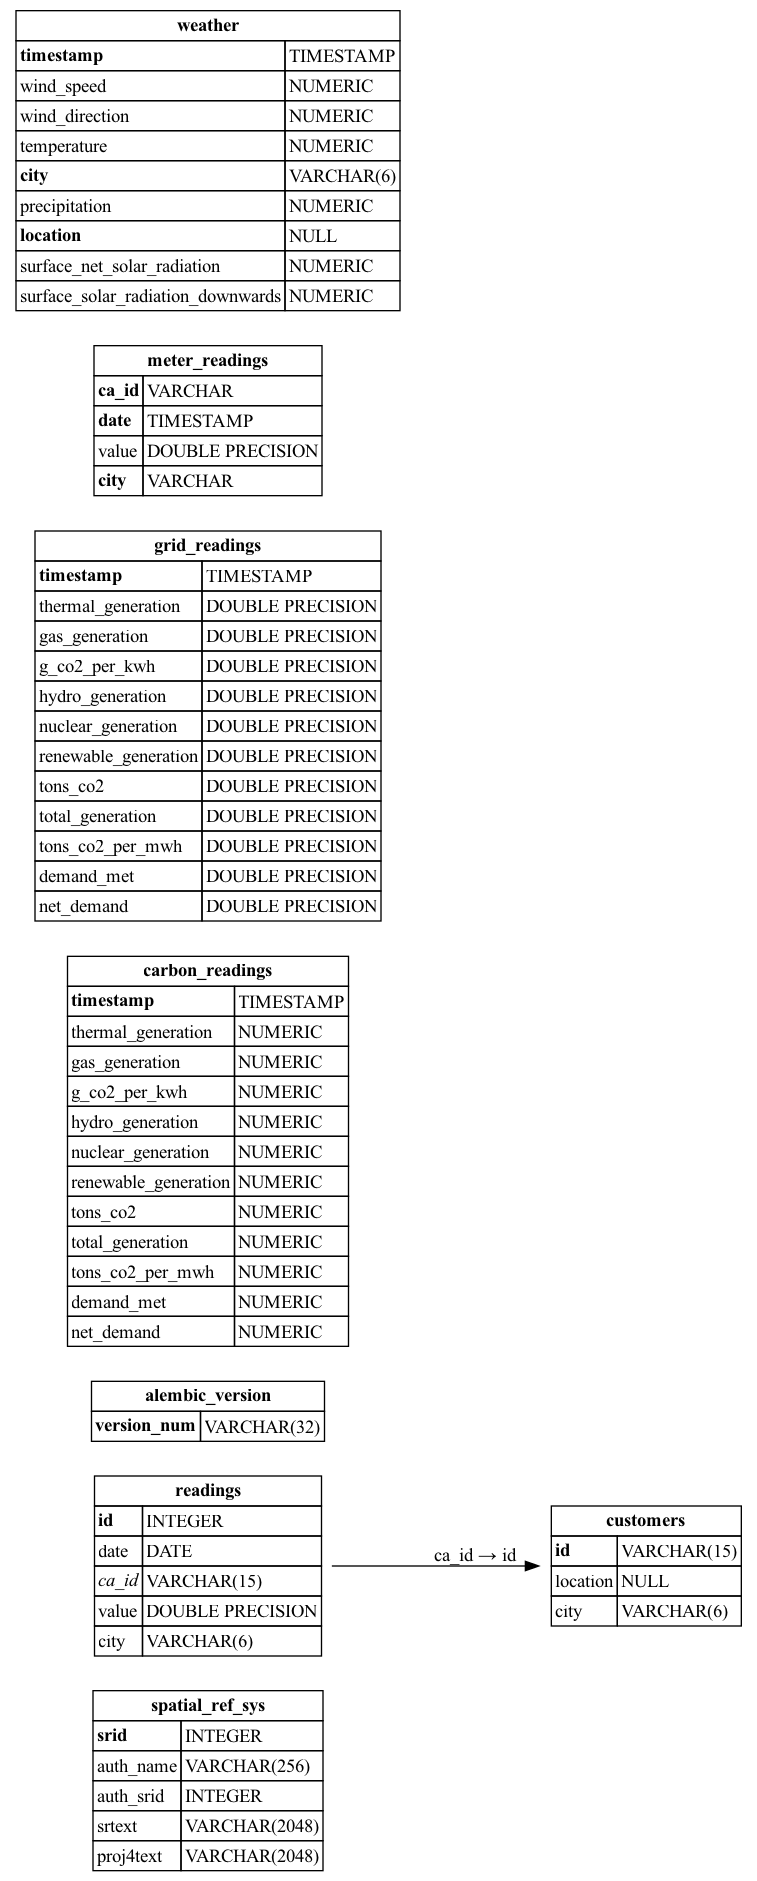

In [ ]:
display(Image(filename=(os.path.join(outputs_images_hitachi_diagrams,"public_schema_diagram.png"))))

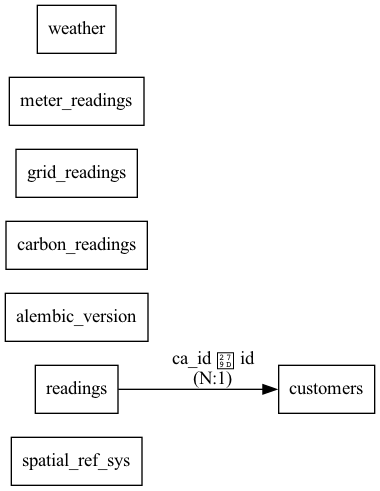

In [ ]:
display(Image(filename=(os.path.join(img_save_directory, "public_relationship_diagram.png"))))

#### Other Schemas

There are other schemas in the database. They are not necessarily needed for the analysis in this project, but are investigated at a high level. 

##### tiger

In [ ]:
# Describing the tables in the tiger schema
print("\n" + "-" * 120)
print("Describing tables in the 'tiger' schema:\n" + "-" * 120)
for table in user_tables.get('tiger', []):
    print(f"\nTable: {table}")
    print("------------------------------")
    describe_table(inspector, table, schema='tiger')


------------------------------------------------------------------------------------------------------------------------
Describing tables in the 'tiger' schema:
------------------------------------------------------------------------------------------------------------------------

Table: featnames
------------------------------
gid (INTEGER) — nullable: False
tlid (BIGINT) — nullable: True
fullname (VARCHAR(100)) — nullable: True
name (VARCHAR(100)) — nullable: True
predirabrv (VARCHAR(15)) — nullable: True
pretypabrv (VARCHAR(50)) — nullable: True
prequalabr (VARCHAR(15)) — nullable: True
sufdirabrv (VARCHAR(15)) — nullable: True
suftypabrv (VARCHAR(50)) — nullable: True
sufqualabr (VARCHAR(15)) — nullable: True
predir (VARCHAR(2)) — nullable: True
pretyp (VARCHAR(3)) — nullable: True
prequal (VARCHAR(2)) — nullable: True
sufdir (VARCHAR(2)) — nullable: True
suftyp (VARCHAR(3)) — nullable: True
sufqual (VARCHAR(2)) — nullable: True
linearid (VARCHAR(22)) — nullable: True
mtfcc (VAR

/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_49564/1562869597.py:25: SAWarning: Did not recognize type 'geometry' of column 'the_geom'
  columns = inspector.get_columns(table_name, schema=schema)


gid (INTEGER) — nullable: False
statefp (VARCHAR(2)) — nullable: True
countyfp (VARCHAR(3)) — nullable: True
countyns (VARCHAR(8)) — nullable: True
cntyidfp (VARCHAR(5)) — nullable: False
name (VARCHAR(100)) — nullable: True
namelsad (VARCHAR(100)) — nullable: True
lsad (VARCHAR(2)) — nullable: True
classfp (VARCHAR(2)) — nullable: True
mtfcc (VARCHAR(5)) — nullable: True
csafp (VARCHAR(3)) — nullable: True
cbsafp (VARCHAR(5)) — nullable: True
metdivfp (VARCHAR(5)) — nullable: True
funcstat (VARCHAR(1)) — nullable: True
aland (BIGINT) — nullable: True
awater (DOUBLE PRECISION) — nullable: True
intptlat (VARCHAR(11)) — nullable: True
intptlon (VARCHAR(12)) — nullable: True
the_geom (NULL) — nullable: True

Table: state
------------------------------
gid (INTEGER) — nullable: False
region (VARCHAR(2)) — nullable: True
division (VARCHAR(2)) — nullable: True
statefp (VARCHAR(2)) — nullable: False
statens (VARCHAR(8)) — nullable: True
stusps (VARCHAR(2)) — nullable: False
name (VARCHAR(100)

In [ ]:
# Summarising foreign key relationships in the 'tiger' schema
print("\n" + "-" * 120)
print("Summarizing foreign key relationships in the 'tiger' schema:\n" + "-" * 120)
summarize_relationships(inspector=inspector, schema='tiger')


------------------------------------------------------------------------------------------------------------------------
Summarizing foreign key relationships in the 'tiger' schema:
------------------------------------------------------------------------------------------------------------------------


In [ ]:
logging.getLogger(name='sqlalchemy.engine').setLevel(logging.WARNING)

# Getting primary keys for all tables in the public schema
print("\n" + "-" * 120)
print("Primary keys in the 'tiger' schema:\n" + "-" * 120)
for table in user_tables.get('tiger', []):
    primary_keys = get_primary_keys(inspector=inspector, table_name=table, schema='tiger')
    print(f"Table: {table}, Primary Keys: {primary_keys}")


------------------------------------------------------------------------------------------------------------------------
Primary keys in the 'tiger' schema:
------------------------------------------------------------------------------------------------------------------------
Table: featnames, Primary Keys: ['gid']
Table: geocode_settings, Primary Keys: ['name']
Table: geocode_settings_default, Primary Keys: ['name']
Table: direction_lookup, Primary Keys: ['name']
Table: secondary_unit_lookup, Primary Keys: ['name']
Table: state_lookup, Primary Keys: ['st_code']
Table: street_type_lookup, Primary Keys: ['name']
Table: place_lookup, Primary Keys: ['st_code', 'pl_code']
Table: county_lookup, Primary Keys: ['st_code', 'co_code']
Table: countysub_lookup, Primary Keys: ['st_code', 'co_code', 'cs_code']
Table: zip_lookup_all, Primary Keys: []
Table: zip_lookup_base, Primary Keys: ['zip']
Table: zip_lookup, Primary Keys: ['zip']
Table: county, Primary Keys: ['cntyidfp']
Table: state, Primar

In [ ]:
# Getting foreign keys for all tables in the tiger schema
print("\n" + "-" * 120)
print("Foreign keys in the 'tiger' schema:\n" + "-" * 120)
for table in user_tables.get('tiger', []):
    foreign_keys = get_foreign_keys(inspector=inspector, table_name=table, schema='tiger')
    if foreign_keys:
        print(f"Table: {table}, Foreign Keys: {foreign_keys}")
    else:
        print(f"Table: {table} has no foreign keys.")


------------------------------------------------------------------------------------------------------------------------
Foreign keys in the 'tiger' schema:
------------------------------------------------------------------------------------------------------------------------
Table: featnames has no foreign keys.
Table: geocode_settings has no foreign keys.
Table: geocode_settings_default has no foreign keys.
Table: direction_lookup has no foreign keys.
Table: secondary_unit_lookup has no foreign keys.
Table: state_lookup has no foreign keys.
Table: street_type_lookup has no foreign keys.
Table: place_lookup has no foreign keys.
Table: county_lookup has no foreign keys.
Table: countysub_lookup has no foreign keys.
Table: zip_lookup_all has no foreign keys.
Table: zip_lookup_base has no foreign keys.
Table: zip_lookup has no foreign keys.
Table: county has no foreign keys.
Table: state has no foreign keys.
Table: place has no foreign keys.
Table: zip_state has no foreign keys.
Table: 

In [ ]:
summarize_cardinality_and_ordinality(inspector=inspector, schema='tiger')

From Table           → To Table           Columns                        Cardinality  Ordinality
-----------------------------------------------------------------------------------------------


In [ ]:
# Generating a relationship and schema diagrams for the 'tiger' schema
generate_relationship_diagram(inspector=inspector, schema='tiger', output_file=(os.path.join(outputs_images_hitachi_diagrams,'tiger_relationship_diagram')))
generate_schema_graph(inspector=inspector, schema='tiger', output_file=(os.path.join(outputs_images_hitachi_diagrams, 'tiger_schema_diagram')))

Relationship diagram saved as: outputs/images/hitachi_diagrams/tiger_relationship_diagram.png
Diagram saved as: outputs/images/hitachi_diagrams/tiger_schema_diagram.png


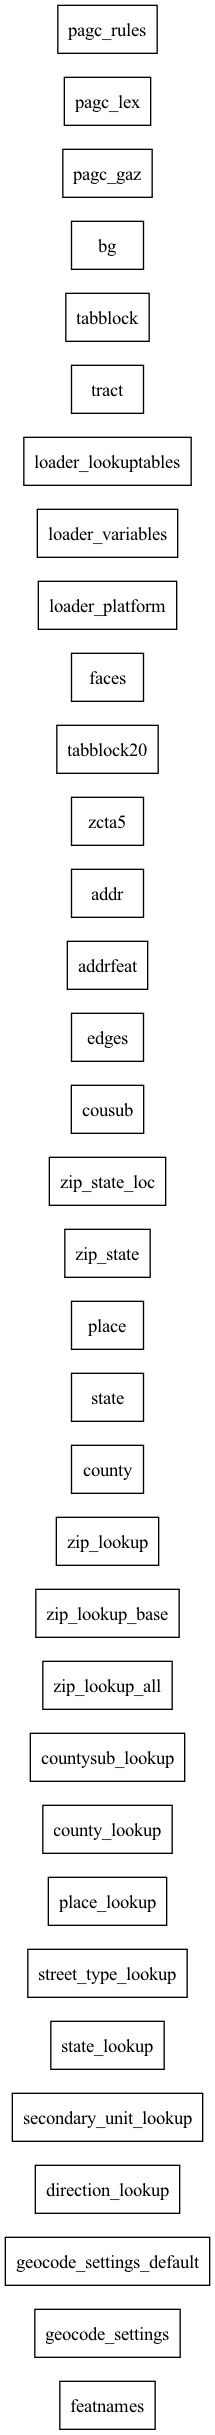

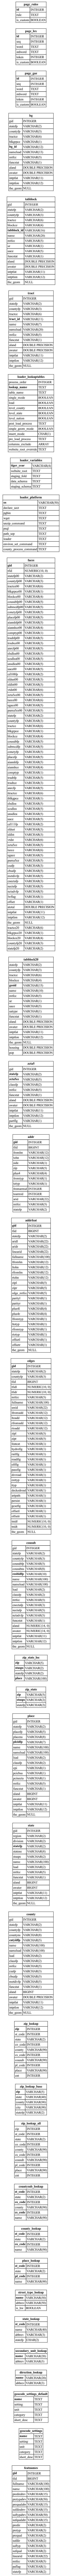

In [ ]:
display(Image(filename=(os.path.join(outputs_images_hitachi_diagrams, "tiger_relationship_diagram.png"))))
display(Image(filename=(os.path.join(outputs_images_hitachi_diagrams, "tiger_schema_diagram.png"))))

##### topology

In [ ]:
# Describing the tables in the topology schema
print("\n------------------------------------------------------------")
print("Describing tables in the 'topology' schema:\n------------------------------------------------------------")
for table in user_tables.get('topology', []):
    print(f"\nTable: {table}")
    print("------------------------------")
    describe_table(inspector=inspector, table_name=table, schema='topology')


------------------------------------------------------------
Describing tables in the 'topology' schema:
------------------------------------------------------------

Table: topology
------------------------------
id (INTEGER) — nullable: False
name (VARCHAR) — nullable: False
srid (INTEGER) — nullable: False
precision (DOUBLE PRECISION) — nullable: False
hasz (BOOLEAN) — nullable: False

Table: layer
------------------------------
topology_id (INTEGER) — nullable: False
layer_id (INTEGER) — nullable: False
schema_name (VARCHAR) — nullable: False
table_name (VARCHAR) — nullable: False
feature_column (VARCHAR) — nullable: False
feature_type (INTEGER) — nullable: False
level (INTEGER) — nullable: False
child_id (INTEGER) — nullable: True


In [ ]:
# Summarising foreign key relationships in the 'topology' schema
print("\n" + "-" * 120)
print("Summarizing foreign key relationships in the 'topology' schema:\n" + "-" * 120)
summarize_relationships(inspector=inspector, schema='topology')


------------------------------------------------------------------------------------------------------------------------
Summarizing foreign key relationships in the 'topology' schema:
------------------------------------------------------------------------------------------------------------------------

Foreign keys in table 'layer':
  - ['topology_id'] → topology(['id'])


In [ ]:
logging.getLogger(name='sqlalchemy.engine').setLevel(level=logging.WARNING)

# Getting primary keys for all tables in the topology schema
print("\n" + "-" * 120)
print("Primary keys in the 'topology' schema:\n" + "-" * 120)
for table in user_tables.get('topology', []):
    primary_keys = get_primary_keys(inspector=inspector, table_name=table, schema='topology')
    print(f"Table: {table}, Primary Keys: {primary_keys}")


------------------------------------------------------------------------------------------------------------------------
Primary keys in the 'topology' schema:
------------------------------------------------------------------------------------------------------------------------
Table: topology, Primary Keys: ['id']
Table: layer, Primary Keys: ['topology_id', 'layer_id']


In [ ]:
# Getting foreign keys for all tables in the topology schema
print("\n" + "-" * 120)
print("Foreign keys in the 'topology' schema:\n" + "-" * 120)
for table in user_tables.get('topology', []):
    foreign_keys = get_foreign_keys(inspector=inspector, table_name=table, schema='topology')
    if foreign_keys:
        print(f"Table: {table}, Foreign Keys: {foreign_keys}")
    else:
        print(f"Table: {table} has no foreign keys.")


------------------------------------------------------------------------------------------------------------------------
Foreign keys in the 'topology' schema:
------------------------------------------------------------------------------------------------------------------------
Table: topology has no foreign keys.
Table: layer, Foreign Keys: [{'name': 'layer_topology_id_fkey', 'constrained_columns': ['topology_id'], 'referred_schema': 'topology', 'referred_table': 'topology', 'referred_columns': ['id'], 'options': {}, 'comment': None}]


In [ ]:
summarize_cardinality_and_ordinality(inspector=inspector, schema='topology')

From Table           → To Table           Columns                        Cardinality  Ordinality
-----------------------------------------------------------------------------------------------
layer                → topology             topology_id                    N:1          mandatory


In [ ]:
# Generating a relationship and schema diagrams for the 'topology' schema
generate_relationship_diagram(inspector=inspector, schema='topology', output_file=(os.path.join(outputs_images_hitachi_diagrams, 'topology_relationship_diagram')))
generate_schema_graph(inspector=inspector, schema='topology', output_file=(os.path.join(outputs_images_hitachi_diagrams, 'topology_schema_diagram')))

Relationship diagram saved as: outputs/images/hitachi_diagrams/topology_relationship_diagram.png
Diagram saved as: outputs/images/hitachi_diagrams/topology_schema_diagram.png


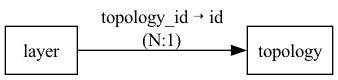

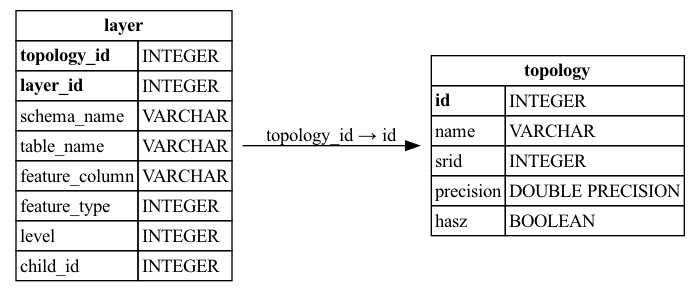

In [ ]:
display(Image(filename=(os.path.join(outputs_images_hitachi_diagrams, "topology_relationship_diagram.png"))))
display(Image(filename=(os.path.join(outputs_images_hitachi_diagrams, "topology_schema_diagram.png"))))

### Pulling and Saving Data from Database

Note this section (as the name indicates) connects to the database and queries it.

The code in this section should be used cautiously to avoid overloading the database with queries.
If you do not require an update or a fresh pull and an older copy will suffice, then a copy saved in local storage should be used if possible.

The database is called 'hitachi' and hostd by the Data Science Institute.

See the **'Local Storage Loading'** section for code to load a locally stored copy.

In [ ]:
## Uncomment these lines to adjust your logging and warnings preferences

# # Set logging level to WARNING to reduce verbosity
# logging.getLogger('sqlalchemy.engine').setLevel(logging.WARNING)

# # Suppresses SQLAlchemy warnings
# warnings.filterwarnings("ignore", category=SAWarning)

The following 4 tables will be queried:
* 'customers'
* 'grid_readings'
* 'weather'
* 'meter_readings'

The following 2 tables are development tables that do not need to be accessed:
* 'carbon_readings'
* 'readings'

#### Core Queries

In [ ]:
# 'weather' table in the 'public' schema
weather_table_pldf = query_to_polars(sql="""SELECT * FROM weather""", engine=engine, schema_infer_range=10000)

# note that the schema_infer_range parameter is set to 10000, which means that Polars will use the first 10,000 rows to infer the schema of the DataFrame.
# this helps Polars to determine the data types of the columns in the DataFrame, which is useful when working with datasets where the schema may not be known in advance.

In [ ]:
# 'customers' table in the 'public' schema
customers_table_pldf = query_to_polars(sql="SELECT * FROM customers", engine=engine)

In [ ]:
# 'grid_readings' table in the 'public' schema
grid_readings_table_pldf = query_to_polars(sql="SELECT * FROM grid_readings", engine=engine)

In [ ]:
years = list_years(user_engine=engine)
print(f"Available years (sampled): {years}")

# This query usually takes about 5 minutes to run, depending on the database load and network speed.

Available years (sampled): [2021, 2022, 2023]


In [ ]:
# The following query takes a very long time to run so it is commented out.

# 'meter_readings' table in the 'public' schema
# meter_readings_table_pldf_reduced = query_to_polars("SELECT * FROM meter_readings LIMIT 100000000", engine)

In [ ]:
# THE BELOW QUERY ran for 37 minutes and was still not finished - so I limited the number of rows returned to 10,000
# meter_readings_table_pldf = query_to_polars("SELECT * FROM meter_readings", engine)
# After experimentation, I was able to run the query with a limit of 1_000_000 rows in about 8 seconds, a query with 10_000_000 rows which takes about 85 seconds, and a query with 100_000_000 rows which takes about 18-24 minutes

In [ ]:
engine.dispose()

#### Saving Data

In [12]:
# Reminder of data directories needed
print(f"base_data_directory: {base_data_directory}")
# Directory where the dataframes will be saved
print(f"hitachi_data_directory: {hitachi_data_directory}")

base_data_directory: ../../data
hitachi_data_directory: ../../data/hitachi


In [13]:
# Isolate the contents of the 'save_directory' to show the saved dataframes currently in the directory (if any)
print("\n" + "-" * 120)
print(f"Contents of '{hitachi_data_directory}' directory:\n" + "-" * 120)
for f in sorted(os.listdir(path=hitachi_data_directory)):
    print(f"  - {f}")


------------------------------------------------------------------------------------------------------------------------
Contents of '../../data/hitachi' directory:
------------------------------------------------------------------------------------------------------------------------
  - .DS_Store
  - customers_20250714_1401.parquet
  - grid_readings_20250714_1401.parquet
  - grid_readings_20250714_1401_processed.parquet
  - grid_readings_20250714_1401_processed_half_hourly.parquet
  - meter_primary_files
  - weather_20250714_1401.parquet
  - weather_20250714_1401_processed.parquet
  - weather_and_grid_data_half-hourly_20250714_1401.parquet
  - weather_data_combined_20250714_1401.parquet


In [ ]:
# Setting the timestamp for file naming
timestamp = datetime.now().strftime("%Y%m%d_%H%M")  # Current timestamp for file naming (YYYYMMDD_HHMM)

# Saving the dataframes to Parquet files
# Parquet is a columnar storage file format that is optimized for use with big datasets and database-like data.
# Full tables
customers_table_pldf.write_parquet(file=os.path.join(hitachi_data_directory, f'customers_{timestamp}.parquet'))
grid_readings_table_pldf.write_parquet(file=os.path.join(hitachi_data_directory, f'grid_readings_{timestamp}.parquet'))
weather_table_pldf.write_parquet(file=os.path.join(hitachi_data_directory, f'weather_{timestamp}.parquet'))

# Reduced set of meter readings
# meter_readings_table_pldf_reduced.write_parquet(file=os.path.join(hitachi_data_directory, f'meter_readings_{timestamp}.parquet'))

# Note:
# I was only able to run full queries on 'customers', 'grid_readings' and 'weather'
# - a reduced set of 100,000,000 rows was pulled for 'meter_readings'
# I did not have access to the 'carbon_readings' and 'readings' tables, so I could not pull them.

In [15]:
# View the contents of the save directory after saving the dataframes
print("\n" + "-" * 120)
print(f"Contents of '{hitachi_data_directory}' directory:\n" + "-" * 120)
for f in sorted(os.listdir(path=hitachi_data_directory)):
    print(f"  - {f}")


------------------------------------------------------------------------------------------------------------------------
Contents of '../../data/hitachi' directory:
------------------------------------------------------------------------------------------------------------------------
  - .DS_Store
  - customers_20250714_1401.parquet
  - grid_readings_20250714_1401.parquet
  - grid_readings_20250714_1401_processed.parquet
  - grid_readings_20250714_1401_processed_half_hourly.parquet
  - meter_primary_files
  - weather_20250714_1401.parquet
  - weather_20250714_1401_processed.parquet
  - weather_and_grid_data_half-hourly_20250714_1401.parquet
  - weather_data_combined_20250714_1401.parquet


#### Development Notes

I was initially unable to pull the following datasets due to other errors:
* **'weather'**
    * I was initially unable to pull this data using the command `weather_table_pldf = query_to_polars("SELECT * FROM weather", engine)`
    * I received the following message: ` ComputeError: could not append value: 6.0656898294685035 of type: decimal[*,16] to the builder; `  
                                        ` make sure that all rows have the same schema or consider increasing 'infer_schema_length' `
    * I believe this error is because the NUMERIC type native to the database exceeds the precision limits default in polars or in python
    * There were two potential fixes to this:
        1. Increase the inference range (10000 ended up working)
        2. Modify the query so the data types would be compatible with polars
            * `SELECT timestamp,`  
                `CAST(wind_speed AS DOUBLE PRECISION) AS wind_speed,`  
                `CAST(wind_direction AS DOUBLE PRECISION) AS wind_direction,`  
                `CAST(temperature AS DOUBLE PRECISION) AS temperature,`  
                `city,`  
                `CAST(precipitation AS DOUBLE PRECISION) AS precipitation,`  
                `location`  
            `FROM weather` 
    * The modification of the inference range ended up working, the query modification itself did not work, but combined with the inference range change did.
* **'meter_readings'**
    * I attempted to run `meter_readings_table_pldf = query_to_polars("SELECT * FROM meter_readings", engine)` but after 37 minutes, it was still not finished.
    * I then limited the number of rows returned to 10,000 and this executed in less than 1 second.
    * After experimentation, I was able to run the query with a limit of 10,000,000 which executed in about 85 seconds.

## Loading Data from Local Save

Finally, after saving, we attempt to load the data we just pulled to ensure that everything is working correctly.

In [21]:
# Reminder of data directory structure and contents

# This is a redundant code block, but it is included for reference as a reminder of the directory variables and their contents.
# base_data_directory = 'data'  # Base directory where the dataframes will be saved
# hitachi_data_directory = 'data/hitachi_copy'  # Directory where the dataframes will be

print("\n" + "-" * 120)
print(f"Contents of '{base_data_directory}' and subdirectories:\n" + "-" * 120)
for root, dirs, files in sorted(os.walk(top=base_data_directory)):
    for f in sorted(files):
        rel_dir = os.path.relpath(path=root, start=base_data_directory)
        rel_file = os.path.join(rel_dir, f) if rel_dir != '.' else f
        print(f"  - {rel_file}")


------------------------------------------------------------------------------------------------------------------------
Contents of '../../data' and subdirectories:
------------------------------------------------------------------------------------------------------------------------
  - .DS_Store
  - hitachi/.DS_Store
  - hitachi/customers_20250714_1401.parquet
  - hitachi/grid_readings_20250714_1401.parquet
  - hitachi/grid_readings_20250714_1401_processed.parquet
  - hitachi/grid_readings_20250714_1401_processed_half_hourly.parquet
  - hitachi/weather_20250714_1401.parquet
  - hitachi/weather_20250714_1401_processed.parquet
  - hitachi/weather_and_grid_data_half-hourly_20250714_1401.parquet
  - hitachi/weather_data_combined_20250714_1401.parquet
  - hitachi/meter_primary_files/.DS_Store
  - hitachi/meter_primary_files/meter_readings_2021_20250714_2015.parquet
  - hitachi/meter_primary_files/meter_readings_2021_20250714_2015_formatted.parquet
  - hitachi/meter_primary_files/meter_

In [20]:
# Isolate the contents of the 'hitachi_data_directory' to show names of the files we want to retrieve
print("\n" + "-" * 120)
print(f"Contents of '{hitachi_data_directory}' directory:\n" + "-" * 120)
for f in sorted(os.listdir(path=hitachi_data_directory)):
    print(f"  - {f}")


------------------------------------------------------------------------------------------------------------------------
Contents of '../../data/hitachi' directory:
------------------------------------------------------------------------------------------------------------------------
  - .DS_Store
  - customers_20250714_1401.parquet
  - grid_readings_20250714_1401.parquet
  - grid_readings_20250714_1401_processed.parquet
  - grid_readings_20250714_1401_processed_half_hourly.parquet
  - meter_primary_files
  - weather_20250714_1401.parquet
  - weather_20250714_1401_processed.parquet
  - weather_and_grid_data_half-hourly_20250714_1401.parquet
  - weather_data_combined_20250714_1401.parquet


In [22]:
# File names copied from the output of the above code block
weather_table_pldf_local = pl.read_parquet(source=os.path.join(hitachi_data_directory, 'weather_20250714_1401.parquet'))
customers_table_pldf_local = pl.read_parquet(source=os.path.join(hitachi_data_directory, 'customers_20250714_1401.parquet'))
grid_readings_table_pldf_local = pl.read_parquet(source=os.path.join(hitachi_data_directory, 'grid_readings_20250714_1401.parquet'))

In [23]:
# Displaying the first 5 rows of each DataFrame to verify the data has been loaded correctly
print("\n" + "-" * 120)
print("Head of the 'weather_table_pldf_local' DataFrame:")
display(weather_table_pldf_local.head(n=5))
print("\n" + "-" * 120)
print("Head of the 'customers_table_pldf_local' DataFrame:")
print("Note: 'customers_table_pldf_local' display is commented out to preserve customer privacy")
# display(customers_table_pldf_local.head(n=5))
print("\n" + "-" * 120)
print("Head of the 'grid_readings_table_pldf_local' DataFrame:")
display(grid_readings_table_pldf_local.head(n=5))


------------------------------------------------------------------------------------------------------------------------
Head of the 'weather_table_pldf_local' DataFrame:


timestamp,wind_speed,wind_direction,temperature,city,precipitation,location,surface_net_solar_radiation,surface_solar_radiation_downwards
datetime[μs],"decimal[38,18]","decimal[38,20]","decimal[38,15]",str,"decimal[38,28]",str,"decimal[38,17]","decimal[38,17]"
2024-12-13 13:00:00,8.013575020999754000,105.09231811866465000000,15.975219726562500,"""delhi""",0.0000000000000000000000000000,"""0101000020E6100000F6285C8FC255…",12296608.00000000000000000,14926616.00000000000000000
2024-12-13 14:00:00,8.289883957905610000,110.72614327536141000000,14.646026611328125,"""delhi""",0.0000000000000000000000000000,"""0101000020E6100000F6285C8FC235…",12108108.00000000000000000,14736050.00000000000000000
2024-12-13 14:00:00,8.336890954411203000,110.27725102589554000000,14.629241943359375,"""delhi""",0.0000000000000000000000000000,"""0101000020E61000005C8FC2F5283C…",12149601.00000000000000000,14737817.00000000000000000
2024-12-13 14:00:00,8.403726468287198000,109.70666556656998000000,14.623779296875000,"""delhi""",0.0000000000000000000000000000,"""0101000020E6100000C2F5285C8F42…",12240716.00000000000000000,14738703.00000000000000000
2024-12-13 14:00:00,8.454637190808407000,109.04352821446052000000,14.611297607421875,"""delhi""",0.0000000000000000000000000000,"""0101000020E6100000285C8FC2F548…",12278334.00000000000000000,14740205.00000000000000000



------------------------------------------------------------------------------------------------------------------------
Head of the 'customers_table_pldf_local' DataFrame:
Note: 'customers_table_pldf_local' display is commented out to preserve customer privacy

------------------------------------------------------------------------------------------------------------------------
Head of the 'grid_readings_table_pldf_local' DataFrame:


timestamp,thermal_generation,gas_generation,g_co2_per_kwh,hydro_generation,nuclear_generation,renewable_generation,tons_co2,total_generation,tons_co2_per_mwh,demand_met,net_demand
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2022-01-04 17:05:00,136202.0,2901.0,815.573088,10113.0,5211.0,9900.0,11168.3899,164327.0,0.815573,162948.0,154427.0
2022-01-04 17:10:00,136202.0,2901.0,815.573088,10113.0,5211.0,9900.0,11168.3899,164327.0,0.815573,162948.0,154427.0
2022-01-04 17:15:00,136202.0,2901.0,815.573088,10113.0,5211.0,9900.0,11168.3899,164327.0,0.815573,162948.0,154427.0
2022-01-04 17:20:00,136202.0,2901.0,815.573088,10113.0,5211.0,9900.0,11168.3899,164327.0,0.815573,162948.0,154427.0
2022-01-04 17:25:00,136202.0,2901.0,815.573088,10113.0,5211.0,9900.0,11168.3899,164327.0,0.815573,162948.0,154427.0


In [ ]:
# Final cleanup in case the engine is still connected
if engine:
    try:
        engine.dispose()
        print("Database engine disposed successfully.")
    except Exception as e:
        print(f"Error during engine disposal: {e}")

Database engine disposed successfully.
